In [1]:
import numpy as np
import matplotlib.pyplot as plt
from sklearn.datasets import make_blobs
from sklearn.svm import SVC

In [2]:
X,y = make_blobs(200,2,centers=2,random_state=2)

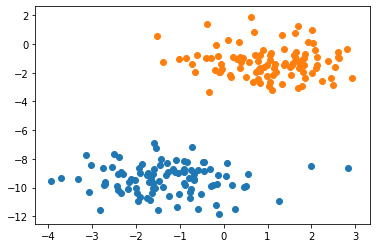

In [3]:
def plot_blobs(X,y):
    plt.clf()
    plt.scatter(X[y==0,0],X[y==0,1])
    plt.scatter(X[y==1,0],X[y==1,1])
    plt.show()
plot_blobs(X,y)

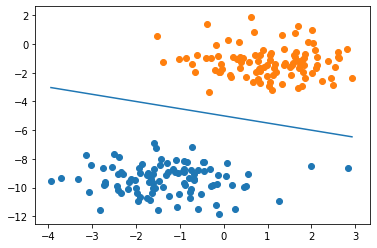

In [4]:
def plot_decision_boundary(w,X,y):
    x = np.linspace(X[:,0].min(),X[:,0].max(),200)
    x2 = -(w[0] * x + w[2]) / w[1]
    plt.clf()
    plt.scatter(X[y==0,0],X[y==0,1])
    plt.scatter(X[y==1,0],X[y==1,1])
    plt.plot(x,x2)
    plt.show()
plot_decision_boundary(np.array([1,2,10]),X,y)# 瞎猫碰死耗子

In [5]:
w = np.array([1, 2, 10])
w_l2_norm = np.linalg.norm(w , ord=2)

In [6]:
x_decision_boundary = np.linspace(X[:,0].min(),X[:,0].max(),200)
#y = x_decision_boundary.dot(w)
#x_decision_boundary.
x = np.linspace(X[:,0].min(),X[:,0].max(),200)
x2 = -(w[0] * x + w[2]) / w[1]

In [7]:
X[:10]

array([[ 0.38115481, -1.64481461],
       [-0.58390398, -8.78405909],
       [ 1.83086535, -1.42523455],
       [ 1.81313467, -1.92467083],
       [-1.65577138, -9.55594613],
       [-0.13265422, -0.80505548],
       [-2.69891251, -9.73324948],
       [ 0.18757605, -9.8171527 ],
       [ 1.92513692,  0.17477999],
       [-0.24707289, -9.8104778 ]])

In [8]:
X_b = np.c_[X,np.ones(X.shape[0])]
X_b[:10]

array([[ 0.38115481, -1.64481461,  1.        ],
       [-0.58390398, -8.78405909,  1.        ],
       [ 1.83086535, -1.42523455,  1.        ],
       [ 1.81313467, -1.92467083,  1.        ],
       [-1.65577138, -9.55594613,  1.        ],
       [-0.13265422, -0.80505548,  1.        ],
       [-2.69891251, -9.73324948,  1.        ],
       [ 0.18757605, -9.8171527 ,  1.        ],
       [ 1.92513692,  0.17477999,  1.        ],
       [-0.24707289, -9.8104778 ,  1.        ]])

In [9]:
np.sum(X_b.dot(w) < 0)

100

In [10]:
np.sum(X_b.dot(w)==X_b.dot(w.T))

200

In [11]:
np.abs(X_b.dot(w.T))[:10]

array([ 7.09152559,  8.15202216,  8.98039625,  7.96379301, 10.76766363,
        8.25723481, 12.16541147,  9.44672935, 12.27469689,  9.86802849])

In [12]:
X_b.dot(w.T)[:10]

array([  7.09152559,  -8.15202216,   8.98039625,   7.96379301,
       -10.76766363,   8.25723481, -12.16541147,  -9.44672935,
        12.27469689,  -9.86802849])

In [13]:
def distance(w,x):
    w_l2_norm = np.linalg.norm(w, ord=2)
    dividened = x.dot(w.T)
    return dividened / w_l2_norm

In [14]:
def distance_matrix(w,X_b):
    w_l2_norm = np.linalg.norm(w, ord=2)
    dividened = X_b.dot(w.T)
    return dividened / w_l2_norm
distance_matrix(w,X_b)[:3]

array([ 0.69206203, -0.7955559 ,  0.87639694])

In [15]:
# (1/2) * ||w||^2
def gap(w):
    return (np.linalg.norm(w,ord=2) ** 2) * 1. / 2.
gap(w)

52.49999999999999

In [16]:
def plot_intercept_change():
    x = np.linspace(X[:,0].min(),X[:,0].max(),200)
    w = np.array([1,2,10])
    gaps = np.arange(-10,10,1)
#    subp = 100 * len(gaps)+10
#    print(subp)
    fig = plt.figure(figsize=(3,len(gaps)*3))
    gs = fig.add_gridspec(len(gaps), 1)
    for i ,gap in enumerate(gaps):
        w[2] = gap
        print(w)
        x2 = -(w[0] * x + w[2]) / w[1]
        ax = fig.add_subplot(gs[i,0])
        ax.set_title("b = {0}".format(w[2]))
        ax.grid(True)
        ax.scatter(X[y==0,0],X[y==0,1])
        ax.scatter(X[y==1,0],X[y==1,1])
        ax.plot(x,x2)
    plt.show()
#plot_intercept_change()

In [17]:
def clip(alpha, L, H):
    '''
    修剪alpha的值到L和H之间.
    '''
    if alpha < L:
        return L
    elif alpha > H:
        return H
    else:
        return alpha
    
def select_j(i, m):
    '''
    在m中随机选择除了i之外剩余的数
    '''
    l = np.arange(10)
    seq = np.r_[l[: i],l[i+1:]]
    return np.random.choice(seq)

In [18]:
def simple_smo(X, y, C, max_iter=100, epsilon=1e-5):
    '''
    简化版SMO算法实现，未使用启发式方法对alpha对进行选择.
    :param X: 所有特征数据向量
    :param y: 所有的数据标签
    :param C: 软间隔常数, 0 <= alpha_i <= C
    :param max_iter: 外层循环最大迭代次数
    '''
    # dataset = np.array(dataset)
    # m, n = dataset.shape
    # labels = np.array(labels)
    m , n = X.shape
    # 初始化参数
    alphas = np.zeros(m)
    b = 0
    iters = 0
    
    def f(x):
        '''
        SVM分类器函数 y = w^Tx + b
        SVM对数据点的预测值: Σα_i.y_i.x_i^T * x + b
        '''
        # Kernel function vector.
        x = np.matrix(x).T
        X_matrix = np.matrix(X)
        # 核矩阵
        ks = X_matrix * x
        # Predictive value.
        wx = np.matrix(alphas * y) * ks
        fx = wx + b
        return fx

    while iters < max_iter:
        pair_changed = 0
        # 对每个样本更新一次.
        for i in range(m):
            # alpha1
            a_i, x_i, y_i = alphas[i], X[i], y[i]
            fx_i = f(x_i)
            # E_i预测值与真实值的误差.
            E_i = fx_i - y_i
            # alpha2 
            j = select_j(i, m)
            a_j, x_j, y_j = alphas[j], X[j], y[j]
            fx_j = f(x_j)
            # E_j预测值与真实值的误差.
            E_j = fx_j - y_j
            # 核矩阵元素
            K_ii, K_jj, K_ij = np.dot(x_i, x_i), np.dot(x_j, x_j), np.dot(x_i, x_j)
            eta = K_ii + K_jj - 2 * K_ij
            if eta <= 0:
                print('WARNING  eta <= 0')
                continue
            # 获取更新的alpha对
            a_i_old, a_j_old = a_i, a_j
            # 通过对alpha2求一阶导数得到新的alpha2
            a_j_new = a_j_old + y_j * (E_i - E_j) / eta
            # 因有限制条件约束,对alpha进行修剪,Bosk Constraint
            if y_i != y_j:
                L = max(0, a_j_old - a_i_old)
                H = min(C, C + a_j_old - a_i_old)
            else:
                L = max(0, a_i_old + a_j_old - C)
                H = min(C, a_j_old + a_i_old)
            a_j_new = clip(a_j_new, L, H)
            # 得到alpha1
            a_i_new = a_i_old + y_i * y_j * (a_j_old - a_j_new)
            if abs(a_j_new - a_j_old) < epsilon:
                #print('WARNING   alpha_j not moving enough')
                continue
            alphas[i], alphas[j] = a_i_new, a_j_new
            # 更新阈值b
            b_i = -E_i - y_i*K_ii*(a_i_new - a_i_old) - y_j*K_ij*(a_j_new - a_j_old) + b
            b_j = -E_j - y_i*K_ij*(a_i_new - a_i_old) - y_j*K_jj*(a_j_new - a_j_old) + b
            if 0 < a_i_new < C:
                b = b_i
            elif 0 < a_j_new < C:
                b = b_j
            else:
                b = (b_i + b_j)/2
            pair_changed += 1
            #print('INFO   iteration:{}  i:{}  pair_changed:{}'.format(iters, i, pair_changed))
        if pair_changed == 0:
            iters += 1
        else:
            iters = 0
        #print('iteration number: {}'.format(iters))
    
    return alphas, b

In [19]:
# simple_smo(X, y, 0.6)

In [20]:
def get_w(alphas, X, y):
    '''
    通过已知数据点和拉格朗日乘子获得分割超平面参数w
    '''
    alphas, X, y = np.array(alphas), np.array(X), np.array(y)
    yx = y.reshape(1, -1).T * np.array([1, 1]) * X
    w = np.dot(yx.T, alphas)
    return w

[0.1246171  0.36005037] [[2.18054993]]


<Figure size 432x288 with 0 Axes>

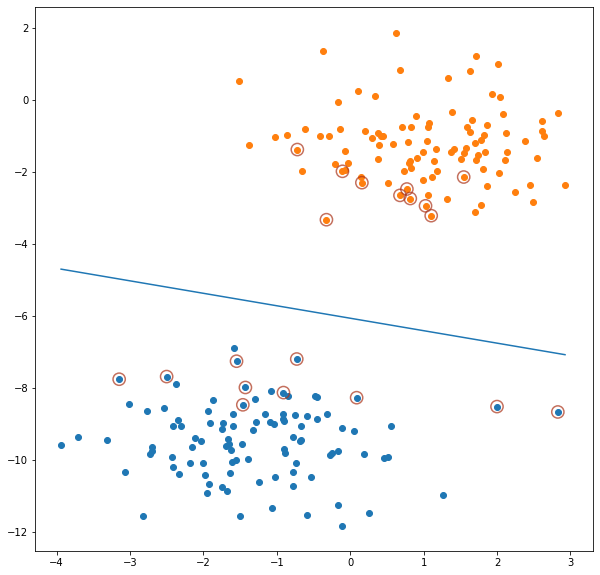

In [21]:
y[y==0] = -1 # 坑在这里.
C = 0.4
# 加载训练数据
alphas, b = simple_smo(X , y, C)
#print(alphas)

plt.clf()
fig = plt.figure(figsize=(10,10))
ax = fig.add_subplot(111)
# 绘制数据点
ax.scatter(X[y==-1, 0], X[y==-1, 1], label='+1')
ax.scatter(X[y==1, 0], X[y==1, 1], label='-1')

# 绘制分割线
w = get_w(alphas, X, y)
print(w,b)
x1, _ = max(X, key=lambda x: x[0])
x2, _ = min(X, key=lambda x: x[0])
a1, a2 = w
y1, y2 = (-b - a1*x1) / a2, (-b - a1*x2) / a2
# 还可以这么做
ax.plot(np.array([x1, x2]).ravel(), np.array([y1, y2]).ravel())

# 绘制支持向量
for i, alpha in enumerate(alphas):
    if abs(alpha) > 1e-3:
        #x, y = X[i]
        ax.scatter(X[i ,0], X[i ,1], s=150, c='none', alpha=0.7,
                   linewidth=1.5, edgecolor='#AB3319')
plt.show()

In [22]:
from sklearn.svm import SVC
svc = SVC(C=0.4,kernel='linear')
y[y==-1]=0
svc.fit(X,y)

SVC(C=0.4, cache_size=200, class_weight=None, coef0=0.0,
    decision_function_shape='ovr', degree=3, gamma='auto_deprecated',
    kernel='linear', max_iter=-1, probability=False, random_state=None,
    shrinking=True, tol=0.001, verbose=False)

In [23]:
svc.coef_

array([[0.17100497, 0.49889243]])

In [24]:
svc.intercept_

array([2.71132883])

In [25]:
svc.support_vectors_

array([[-1.5841884 , -6.8961805 ],
       [-0.72864791, -7.18926735],
       [-0.32431771, -3.31914574]])

In [26]:
from sklearn.datasets import make_classification

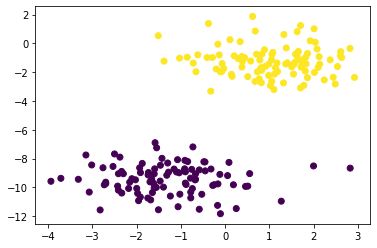

In [27]:
y[y==0]=-1
plt.scatter(X[:,0],X[:,1],c=y)
plt.show()

In [28]:
alphas, b = simple_smo(X , y, C)
alphas, b = np.array(alphas), np.array(b)
w = get_w(alphas, X, y)
w = w.ravel()
b = b.ravel()

In [29]:
w_ = np.r_[w,b]
w_

array([0.09729524, 0.36141453, 2.21344991])

[ 2.98733865 -0.14063119 -0.86537757]


<Figure size 432x288 with 0 Axes>

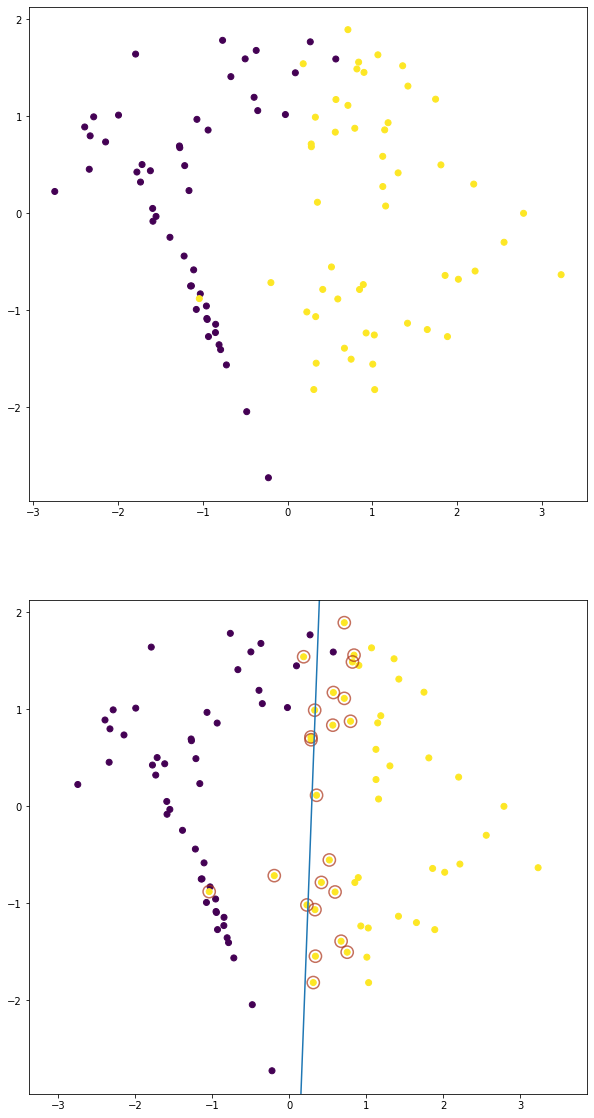

In [30]:
def plot_svm_decision_boundary(X,y,C=0.4):
    # 加载训练数据
    alphas, b = simple_smo(X , y, C)
    #print(alphas)
    plt.clf()
    fig = plt.figure(figsize=(10,20))
    ax1 = fig.add_subplot(211)
    ax1.scatter(X[:,0],X[:,1],c=y)
    ax2 = fig.add_subplot(212)
    # 绘制数据点
    ax2.scatter(X[:,0],X[:,1],c=y)

    # 绘制分割线
    w = get_w(alphas, X, y)
    w = np.array(w).ravel()
    b = np.array(b).ravel()
    w_ = np.r_[w,b]
    print(w_)

    xlim = ax2.get_xlim()
    ylim = ax2.get_ylim()
    ax2.set_ylim(ylim) # 巨大的2Y 是怎么回事??
    x_min,x_max= xlim[0],xlim[1] 
    x1 = np.linspace(x_min,x_max,50)
    x2 = -(w_[0] * x1 + w_[2]) / w_[1]
    ax2.plot(x1,x2)
    # 绘制支持向量
    ax2.scatter(
        X[abs(alphas) > 1e-3 ,0]
        , X[abs(alphas) > 1e-3 ,1]
        , s=150
        , c='none'
        , alpha=0.7
        , linewidth=1.5
        , edgecolor='#AB3319'
    )
    plt.show()
    
X,y = make_classification(n_samples=100,n_features = 2,n_informative=2,n_redundant=0, random_state=5)
plot_svm_decision_boundary(X,y)